In [84]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import Lasso
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import scikitplot as skplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix

In [172]:
plays_df=pd.read_csv("Superbowel_plays.csv")
games_df=pd.read_csv("Superbowel_Games.csv")
#print(games_df.columns)
#df=pd.merge(plays_df,games_df,how="inner",on="gameId")
print(plays_df.columns)
#print(games_df.columns)
#df['target']=df['HomeScore']>df['VisitorScore']
#df.set_index('gameId')
#print(plays_df.head())
#print(plays_df.describe())
#print(games_df.describe())

gameIdList=pd.Series(plays_df['gameId'].value_counts().index)
results=plays_df['gameId'].value_counts()
#i=0
#for item in results:
#    print(gameId[i],item)
#    i+=1


filter=games_df['gameId'].isin(gameIdList)
#print(games_df[filter].head())

teams={}
for key,item in games_df[filter].iterrows():
    #print(item.homeDisplayName)
    teams[item.homeDisplayName]=0
    teams[item.visitorDisplayName]=0
    
#print(teams)

win_results_df=pd.DataFrame(columns=['GameId','Team','TeamOpponent','HomeScore','VisitorScore','Target'])
loss_results_df=pd.DataFrame(columns=['GameId','Team','TeamOpponent','HomeScore','VisitorScore','Target'])

for key,item in teams.items():
    #Home games
    game_filter=(games_df['homeDisplayName']==key)
    win_df=games_df[game_filter]['HomeScore']>games_df[game_filter]['VisitorScore']
    for oppKey,teamOpponent in games_df[(game_filter) & (win_df)].iterrows():
        #print(key,teamOpponent['visitorDisplayName'])
        df_length = len(win_results_df)
        win_results_df.loc[df_length] = [teamOpponent['gameId'],key,teamOpponent['visitorDisplayName'],teamOpponent['HomeScore'],teamOpponent['VisitorScore'],True]

for key,item in teams.items():
    #Home games
    game_filter=(games_df['homeDisplayName']==key)
    loss_df=games_df[game_filter]['HomeScore']<games_df[game_filter]['VisitorScore']
    for oppKey,teamOpponent in games_df[(game_filter) & (loss_df)].iterrows():
        #print(key,teamOpponent['visitorDisplayName'])
        df_length = len(loss_results_df)
        loss_results_df.loc[df_length] = [teamOpponent['gameId'],key,teamOpponent['visitorDisplayName'],teamOpponent['HomeScore'],teamOpponent['VisitorScore'],False]

#print(win_results_df.head(100))    
#print(loss_results_df.head(100))    

#print(plays_df['gameId'].value_counts())
#results=plays_df['gameId'].value_counts()



df=pd.concat([win_results_df,loss_results_df])
df['Target']=df['Target'].astype(bool)
df.reset_index()
df.set_index('GameId')
df=df.sort_values(by='GameId')

Index(['gameId', 'playId', 'quarter', 'GameClock', 'down', 'yardsToGo',
       'possessionTeam', 'yardlineSide', 'yardlineNumber', 'offenseFormation',
       'personnel.offense', 'defendersInTheBox', 'numberOfPassRushers',
       'personnel.defense', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'HomeScoreAfterPlay', 'VisitorScoreAfterPlay', 'isPenalty', 'isSTPlay',
       'SpecialTeamsPlayType', 'KickReturnYardage', 'PassLength', 'PassResult',
       'YardsAfterCatch', 'PlayResult', 'playDescription'],
      dtype='object')


In [173]:
#C - Caught
play_filter=plays_df['PassResult']=='C'
grouped=plays_df[play_filter].groupby('gameId')
avg_pass_length=grouped['PassLength'].mean()
throws_caught=grouped['PassLength'].size()
yards_after_catch=grouped['YardsAfterCatch'].median()

#find the total
total_throws=plays_df.groupby('gameId')['PassResult'].size()
#print(plays_df['gameId'].value_counts())

df['avg_pass_length']=0
for key,value in avg_pass_length.items():
    df.loc[df['GameId']==key,'avg_pass_length']=value

df['throws_caught']=0
for key,value in throws_caught.items():
    df.loc[df['GameId']==key,'throws_caught']=value

df['throws_total']=0
for key,value in total_throws.items():
    df.loc[df['GameId']==key,'throws_total']=value
    
df['yards_after_catch']=0
for key,value in yards_after_catch.items():
    df.loc[df['GameId']==key,'yards_after_catch']=value

df['pct_throws_complete'] =df['throws_caught']/df['throws_total']*100
df['score_difference']=df['HomeScore']-df['VisitorScore']


df['Target']=df['Target'].apply(lambda x: 1 if x==True else 0)
        
print(df.head())        
    
#true_false_map={'True':1,'False':0}
#df['Target']=df['Target'].map(true_false_map)

#print(df[df['avg_pass_length']>0].head(100))    

        GameId                  Team         TeamOpponent HomeScore  \
3   2017090700  New England Patriots   Kansas City Chiefs        27   
9   2017091000         Buffalo Bills        New York Jets        21   
15  2017091001         Chicago Bears      Atlanta Falcons        17   
10  2017091002    Cincinnati Bengals     Baltimore Ravens         0   
6   2017091003      Cleveland Browns  Pittsburgh Steelers        18   

   VisitorScore  Target  avg_pass_length  throws_caught  throws_total  \
3            42       0         7.318182             44           177   
9            12       1         4.119048             42           154   
15           23       0         5.787234             47           144   
10           20       0         3.600000             25           139   
6            21       0         5.431818             44           142   

    yards_after_catch  pct_throws_complete score_difference  
3                 4.5            24.858757              -15  
9         

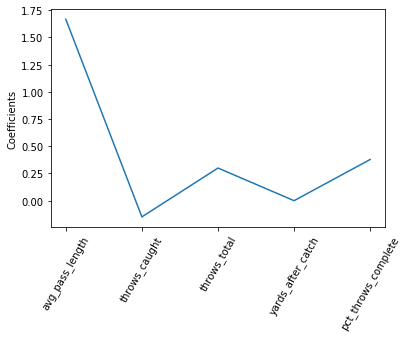

Coefficients important to determine Home Score


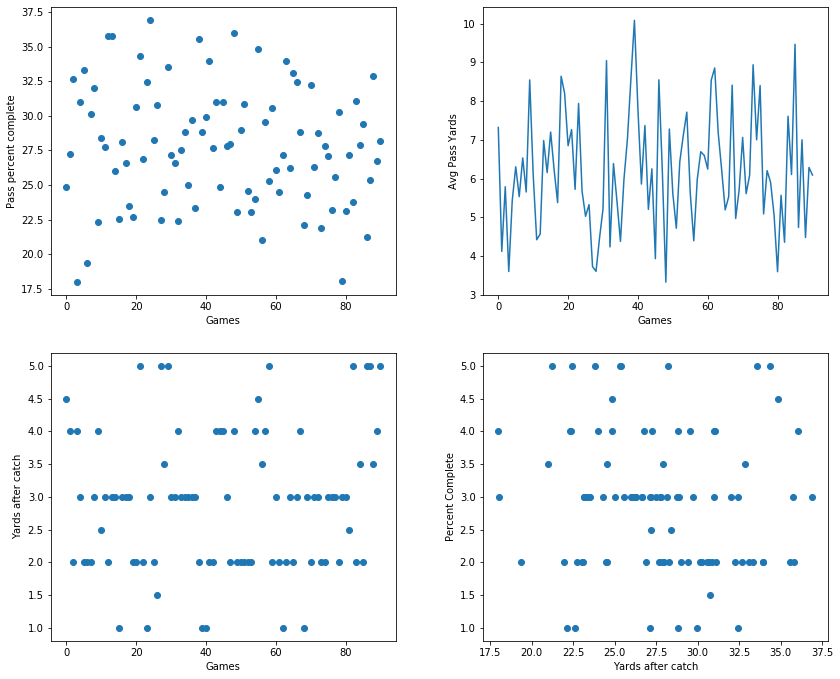

In [174]:
field_names=['avg_pass_length','throws_caught','throws_total','yards_after_catch','pct_throws_complete']
X=df[field_names].copy()
y=df['HomeScore'].copy()


lasso=Lasso(alpha=0.1)
lasso_coef=lasso.fit(X,y).coef_

_ = plt.plot(range(len(field_names)),lasso_coef)
_ = plt.xticks(range(len(field_names)),field_names,rotation=60)
_ = plt.ylabel('Coefficients')

plt.show()

print("Coefficients important to determine Home Score")

x=np.arange(len(df))
ax1 = plt.axes([0, 2, .8, 1])
ax1.plot(x,df['pct_throws_complete'],'o')
plt.ylabel('Pass percent complete')
plt.xlabel('Games')

ax2 = plt.axes([1, 2, .8, 1])
ax2.plot(x,df['avg_pass_length'])
plt.ylabel('Avg Pass Yards')
plt.xlabel('Games')

ax1 = plt.axes([0, .8, .8, 1])
ax1.plot(x,df['yards_after_catch'],'o')
plt.ylabel('Yards after catch')
plt.xlabel('Games')

ax3 = plt.axes([1, .8, .8, 1])
ax3.plot(df['pct_throws_complete'],df['yards_after_catch'],'o')

plt.ylabel('Percent Complete')
plt.xlabel('Yards after catch')
plt.show()






Graphs for a Win at Home


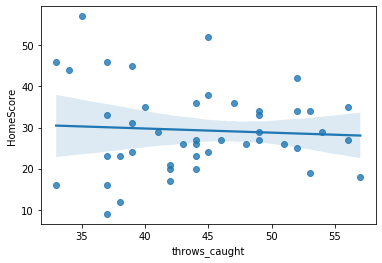

The more throws caught the higher the Home score


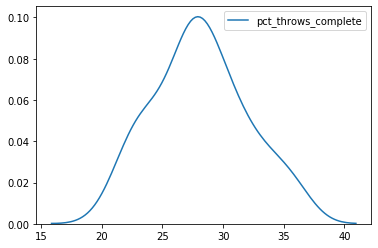

25 to 35 percent represent most of the throws caught


In [175]:
print("Graphs for a Win at Home" )

filter=df['Target']==1
sns.regplot(data=df[filter], x='throws_caught', y='HomeScore')
plt.show()
print('The more throws caught the higher the Home score')

sns.kdeplot(df[filter]['pct_throws_complete'])
plt.show()

print("25 to 35 percent represent most of the throws caught")

Graphs for a Lose at Home


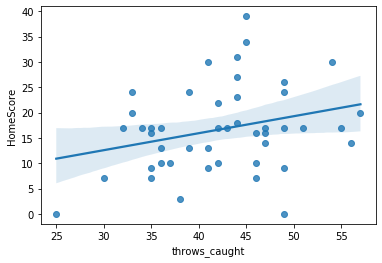

The more throws the caught the higher the Home score


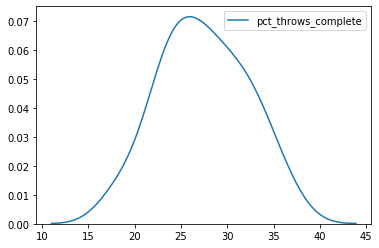

25 to 35 percent represent most of the throws caught
The home score slope is less for loss


In [176]:
print("Graphs for a Lose at Home" )
filter=df['Target']==0
sns.regplot(data=df[filter], x='throws_caught', y='HomeScore')
plt.show()
print('The more throws the caught the higher the Home score')

sns.kdeplot(df[filter]['pct_throws_complete'])
plt.show()

print("25 to 35 percent represent most of the throws caught")

print ("The home score slope is less for loss")


Ave Pass length for a Home Win


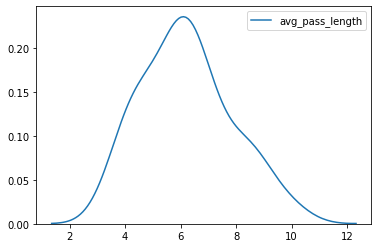

The most common pass length is 6 yards


In [177]:
print("Ave Pass length for a Home Win" )
filter=df['Target']==1
sns.kdeplot(df[filter]['avg_pass_length'])
plt.show()

print("The most common pass length is 6 yards")

Index(['HomeScore', 'avg_pass_length', 'throws_caught', 'throws_total',
       'yards_after_catch', 'pct_throws_complete', 'score_difference'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 3 to 16
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HomeScore            91 non-null     int32  
 1   avg_pass_length      91 non-null     float64
 2   throws_caught        91 non-null     int32  
 3   throws_total         91 non-null     int32  
 4   yards_after_catch    91 non-null     float64
 5   pct_throws_complete  91 non-null     float64
 6   score_difference     91 non-null     int32  
dtypes: float64(3), int32(4)
memory usage: 4.3 KB
None
       HomeScore  avg_pass_length  throws_caught  throws_total  \
count  91.000000        91.000000      91.000000     91.000000   
mean   22.945055         6.205702      43.230769    155.967033   
std    11.361106         1.49

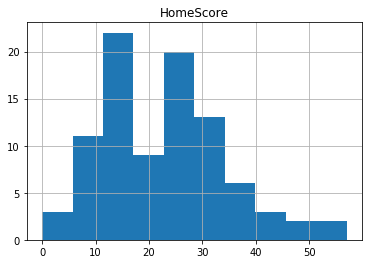

In [178]:
field_names=['HomeScore','avg_pass_length','throws_caught','throws_total','yards_after_catch','pct_throws_complete','score_difference']

#print(df.head())
#dummies_segment=pd.get_dummies(df[['Team','TeamOpponent']])

#df= pd.concat([df,dummies_segment],axis=1)
#del X["Team"]
#del X["TeamOpponent"]

X=df[field_names].copy()
X['HomeScore']=X['HomeScore'].astype(int).fillna(0)
X['avg_pass_length']=X['avg_pass_length'].astype(float).fillna(0)
X['throws_caught']=X['throws_caught'].astype(int).fillna(0)
X['score_difference']=X['score_difference'].astype(int).fillna(0)
X['throws_total']=X['throws_total'].astype(int).fillna(0)
X['yards_after_catch']=X['yards_after_catch'].astype(float).fillna(0)
X['pct_throws_complete']=X['pct_throws_complete'].astype(float).fillna(0)
y=df['Target'].copy()
X.reset_index()
print(X.columns)

print(X.info())
print(X.describe())

X.hist('HomeScore')
plt.show()

#X.to_csv('superbowel_results.csv')
#results= sm.OLS("HomeScore ~ avg_pass_length", data=X).fit()

#X_ols = sm.add_constant(X.values)
#model = sm.OLS(y, X_ols).fit()
#predictions = model.predict(X_ols) 
 
#print_model = model.summary()
#print(print_model)


#a0 = model.params['const']
#a1 = model.params['total_bill']
#a2 = model.params['time']
#a3 = model.params['size']


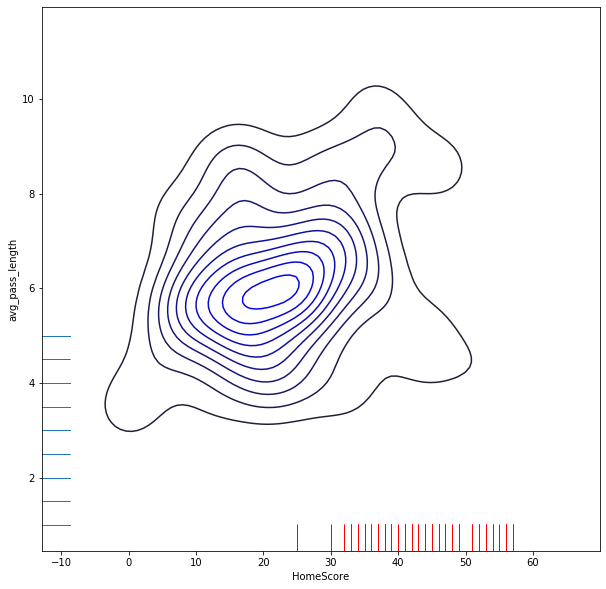

the vertical axis shows yards_after_catch


In [179]:
f, ax = plt.subplots(figsize=(10, 10))
sns.kdeplot(df['HomeScore'], df['avg_pass_length'], color="b", ax=ax)

sns.rugplot(df['throws_caught'], color="r", ax=ax)
sns.rugplot(df['yards_after_catch'], vertical=True, ax=ax)

plt.show()
print("the vertical axis shows yards_after_catch")
print("the most likely yards run after throw caught is 6 yards")

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, stratify = y, random_state = 42)

#L1 regularization called LASSO can be called explicitly, and this approach performs
#feature selection by shrinking some of the model coefficients to zero
#lr = LogisticRegression(C=0.1)
#lr.fit(X_train, y_train) 

#ytrain_pred_probas = lr.predict_proba(X_train)[:, 1]   # prob of predict as 1
#fpr, tpr, thresholds = roc_curve(y_train, ytrain_pred_probas)   # precision_recall_curve
#roc = pd.DataFrame({'FPR':fpr,'TPR':tpr,'Thresholds':thresholds})

#_ = plt.figure()
#plt.plot(roc.FPR, roc.TPR)
#plt.axvline(0.1, color = '#00C851', linestyle = '--')
#plt.xlabel("FPR")
#plt.ylabel("TPR")

Home winning point difference


Text(0.5, 0, 'Point Difference')

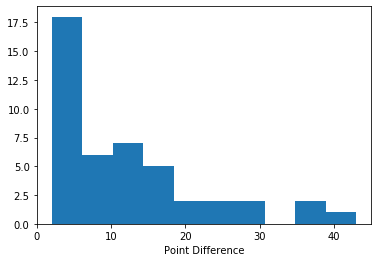

In [181]:
print ("Home winning point difference")
plt.clf()
plt.hist(df[df['Target']==1].score_difference)
plt.xlabel('Point Difference')



In [184]:
def Pmf(data,label):
    total_count=data.count()
    return_df=data.value_counts().rename_axis(label).reset_index(name='Counts')
    return_df["probability"]=return_df["Counts"]/total_count
    return_df=return_df.sort_values(by=label)
    return return_df
def cdf(data,label):
    # sort the data:
    data_sorted = np.sort(data)

    # calculate the proportional values of samples
    p = 1. * np.arange(len(data)) / (len(data) - 1)

    return (pd.DataFrame({label:data_sorted,"probability":p}))

The probability is high that a win will be mostly likely a 25 point game


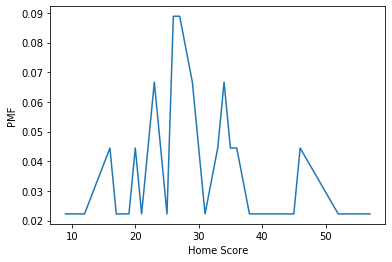

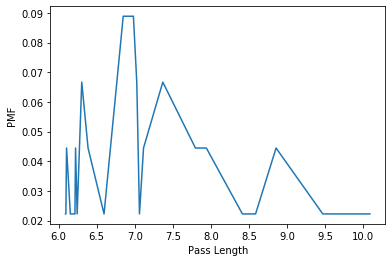

The highest probability for a score is about 35 with a 35% pass completion and 7 yard avg
The accumulative mass function indicates a home score of 35. see below 


In [185]:
print("The probability is high that a win will be mostly likely a 25 point game")
win_filter=df['Target']==1
win_score_proba=Pmf(df[win_filter]['HomeScore'],"HomeScore")
plt.plot(win_score_proba["HomeScore"],score_proba["probability"])
#plt.legend(["Male","Female"])
plt.xlabel("Home Score")
plt.ylabel("PMF")
plt.show()

win_and_pass_filter=(df['Target']==1) & (df['avg_pass_length']>6)

win_score_proba=Pmf(df[win_and_pass_filter]['avg_pass_length'],"avg_pass_length")
plt.plot(win_score_proba["avg_pass_length"],score_proba["probability"])
plt.xlabel("Pass Length")
plt.ylabel("PMF")
plt.show()

print("The highest probability for a score is about 35 with a 35% pass completion and 7 yard avg")
print("The accumulative mass function indicates a home score of 35. see below ")


the Home Score probability at 35 
HomeScore      35.000000
probability     0.872222
dtype: float64


Text(0, 0.5, '$p$')

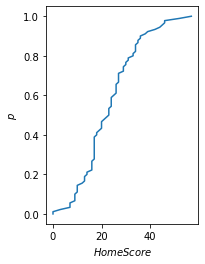

In [186]:
print ("the Home Score probability at 35 ")
accum_df=cdf(X['HomeScore'],"HomeScore")    

print(accum_df[accum_df["HomeScore"]==35].mean())

fig = plt.figure()
ax2 = fig.add_subplot(122)
ax2.plot(accum_df["HomeScore"], accum_df["probability"])
ax2.set_xlabel('$Home Score$')
ax2.set_ylabel('$p$')